In [2]:
# %%writefile ground_functions.py

# This code finds the ground state of a dilute axion star via a shooting method
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.optimize import curve_fit
from scipy import interpolate

# Interval of solution and number of steps
ri, rf, dr = 0, 20, 0.01 # Change dr to 0.001 for high resolution
steps = int((rf - ri)//dr)
rinterv = np.linspace(ri, rf, steps, endpoint=True)

# Right-hand side of ODEs from Eq. (20) in my "Notes on Axion Stars", here X = [\tilde{\Psi}, \chi, \tilde{\phi}, \xi]
def f(r, X):
    f1 = X[1]
    f2 = -2*X[1]/r + 2*X[2]*X[0]
    f3 = X[3]
    f4 = -2*X[3]/r + np.power(X[0],2)
    return np.array([f1, f2, f3, f4])

# Step of RK4
def rk4step(r, X):
    k1 = dr*f(r, X)
    k2 = dr*f(r + dr/2, X + k1/2)
    k3 = dr*f(r + dr/2, X + k2/2)
    k4 = dr*f(r + dr, X + k3)
    return X + (k1 + 2*k2 + 2*k3 + k4)/6

# Full RK4
def rk4(Xbc):
    # Initialize the arrays
    Xs = np.zeros((4, steps))

    # Boundary conditions at r = ri
    Xs[..., 0] = Xbc

    # Perform RK4
    bpoint = 0
    for step in np.arange(1, steps):
        rnow = rinterv[step]
        Xs[..., step] = rk4step(rnow, Xs[..., step - 1])
    
        # The breakpoint 'bpoint' occurs when the solution stops converging to zero at r -> infty
        if Xs[..., step][0] > Xs[..., step - 1][0] or Xs[..., step][0] < 0:
            bpoint = step
            return Xs, bpoint

    return Xs, bpoint

# Step of Monte Carlo for shooting method
def mc_step(phi0, bpointold):
    Xbc_step = np.array([1, 0, phi0, 0])
    Xs_step, bpoint = rk4(Xbc_step)

    # If the breakpoint happens for higher values of r, keep the new solution
    if bpoint > bpointold:
        return True, bpoint
    elif bpoint <= bpointold:
        return False, bpointold

# Full Monte Carlo
def find_sol():
    bpoint = 0
    phi0 = np.random.uniform(-1,0)

    nsteps = 5000
    count, step_stdev = 0, 1
    for i in np.arange(nsteps):
        # Give a random kick to phi0
        phi0old = phi0
        phi0 += np.random.normal(0,step_stdev)

        mcs = mc_step(phi0, bpoint)
        if mcs[0]:  # If a larger 'bpoint' is found, keep
            bpoint = mcs[1]
        else:   # If not, back to old valur of phi0
            phi0 = phi0old
            count += 1
        
        # Variable 'count' avoids the code 'getting stuck' for large periods of time, makes step smaller when it happens
        if count > 100:
            count = 0
            step_stdev = step_stdev/10

        # If the solution does not break in the interval or step is too small, stop
        if bpoint == steps - 1 or step_stdev < 1e-20:
            return phi0, bpoint

    return phi0, bpoint

# Asymptotic behavior of phi
def fit_asymp(r, C, epsilonb):
        return C/r + epsilonb

def find_epsilonb(rinterv_loc, Xs):
    # Find epsilonb from asymptotic behavior of phi
    tail_ini = 100
    r_asymp, phi_asymp = rinterv_loc[-tail_ini:-1], Xs[2].T[-tail_ini:-1]
    popt, pcov = curve_fit(fit_asymp, r_asymp, phi_asymp)
    # The error from the fit is epsilonb_stdev
    epsilonb, epsilonb_stdev = popt[1], np.sqrt(np.diag(pcov))[1] 
    return epsilonb, epsilonb_stdev

The value of epsilonb is: 0.6939841449451077
The value of tilde phi0 is: -0.6494301842346241


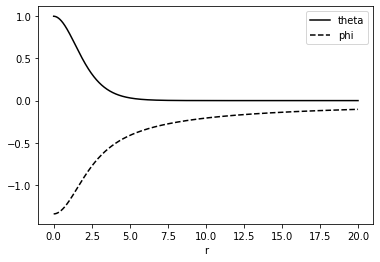

In [2]:
# Plotting solution
phi0_plt = find_sol()[0]
Xbc_plt = np.array([1, 0, phi0_plt, 0])
Xs, bpoint = rk4(Xbc_plt)
rinterv_cut, Xs = rinterv[:bpoint], Xs[:, :bpoint]

epsilonb = find_epsilonb(rinterv_cut, Xs)[0]
print('The value of epsilonb is:', epsilonb)
print('The value of tilde phi0 is:', Xs[2].T[0])

plt.plot(rinterv_cut, Xs[0].T, 'k-', label = "theta")
plt.plot(rinterv_cut, Xs[2].T - epsilonb, 'k--', label = "phi")
plt.xlabel("r")
plt.legend();

epsilonb (high res):  0.6923954131464704
tilde phi0 (high res): -0.6495239603979371


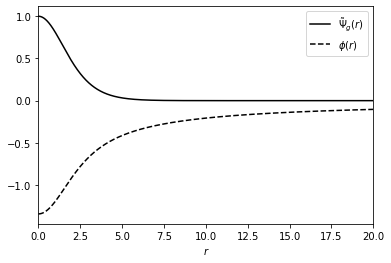

In [3]:
# # Save a high resolution run
# a_file = open("output/hr_ground.txt", "w")
# for row in Xs:
#     np.savetxt(a_file, row)

# a_file.close()

# Plot the high resolution run
Xs_readflat = np.loadtxt("output/hr_ground.txt")
rinterv_read = np.linspace(ri, rf, int(len(Xs_readflat)/4), endpoint=True)
Xs_read = Xs_readflat.reshape(4, int(len(Xs_readflat)/4))

epsilonb_read, epsilonb_read_stdev = find_epsilonb(rinterv_read, Xs_read)
print('epsilonb (high res): ', epsilonb_read)
print('tilde phi0 (high res):', Xs_read[2].T[0])

plt.plot(rinterv_read, Xs_read[0].T, 'k-', label = "$\~\Psi_g(r)$")
plt.plot(rinterv_read, Xs_read[2].T - epsilonb_read, 'k--', label = "$\phi(r)$")
plt.xlabel(r'$r$')
plt.xlim(left = 0, right = 20)
plt.legend()

plt.savefig('plots/ground.pdf', dpi = 300, bbox_inches='tight')

epsilonb: 0.6939841449451077 	 epsilonb (high res): 0.6923954131464704 	 percent error: 0.22945440834416758 %
tilde phi0: -0.6494301842346241 	 tilde phi0 (high res): -0.6495239603979371 	 percent error: 0.014437675748808755 %


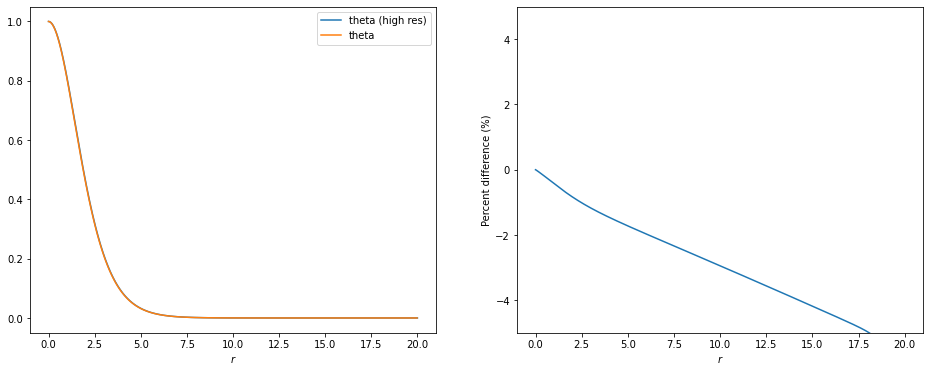

In [4]:
# Comparison with high resolution run
print('epsilonb:', epsilonb, '\t epsilonb (high res):', epsilonb_read, '\t percent error:', np.abs((epsilonb - epsilonb_read)/epsilonb_read)*100, '%')
print('tilde phi0:', Xs[2].T[0], '\t tilde phi0 (high res):', Xs_read[2].T[0],'\t percent error:', np.abs((Xs[2].T[0] - Xs_read[2].T[0])/Xs_read[2].T[0])*100, '%')

figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(rinterv_read, Xs_read[0].T, label = "theta (high res)")
plt.plot(rinterv[:bpoint], Xs[0].T[:bpoint], label = "theta")
plt.xlabel(r'$r$')
plt.legend();

plt.subplot(1, 2, 2)
Xs_interp = interpolate.interp1d(rinterv[:bpoint], Xs[0].T[:bpoint], kind = 'cubic')
Xs_read_interp = interpolate.interp1d(rinterv_read, Xs_read[0].T, kind = 'cubic')
Xs_diff = 100*(Xs_interp(rinterv[:bpoint]) - Xs_read_interp(rinterv[:bpoint]))/Xs_read_interp(rinterv[:bpoint])
plt.plot(rinterv[:bpoint], Xs_diff)
plt.ylim(top = 5, bottom = -5)
plt.xlabel(r'$r$')
plt.ylabel('Percent difference (%)');

In [7]:
# Find the total number of particles in the ground state
Npart = np.trapz(np.power(Xs_read[0].T,2)*np.power(rinterv_read, 2), rinterv_read)
print('Total number of particles (divided by 4*pi): ', Npart)

# Find the radius R99
for i in np.arange(len(rinterv_read)):
    npart = np.trapz(np.power(Xs_read[0].T,2)[:i]*np.power(rinterv_read[:i], 2), rinterv_read[:i])
    if npart > 0.99*Npart:
        r99i = i
        break

print('Radius R99: ', rinterv_read[r99i])

# dPhidr = (Xs_read[0].T[1:] - Xs_read[0].T[:-1])/0.001
# Eb = - np.trapz(np.power(rinterv_read,2)*np.power(Xs_read[0].T,2)*(Xs_read[2].T - epsilonb_read), rinterv_read) - np.trapz(np.power(rinterv_read[:-1]*dPhidr,2), rinterv_read[:-1])

Total number of particles (divided by 4*pi):  2.0736382058420113
Radius R99:  4.835120777788915
